This file is used to download Kaggle datasets into a personal Google Drive.
In order to use this, we need a kaggle.json file, which contains the API credentials.
To obtain a kaggle.json file, sign into your Kaggle account and go to your profile, then 'My Account'. Under the API section, click 'Create New API Token' to generate the kaggle.json file. Afterwards, save it in the same directory as this .ipynb file.

In [ ]:
!pip install -q kaggle
from google.colab import drive
drive.mount('/content/drive')


ModuleNotFoundError: No module named 'google.colab'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##change to your current directory. Afterall, unzip your dataset
!kaggle competitions download -c predict-student-performance-from-game-play -p /content/drive/My\ Drive/Colab\ Notebooks/


In [2]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/predict-student-performance-from-game-play.zip

Archive:  /content/drive/My Drive/Colab Notebooks/predict-student-performance-from-game-play.zip
  inflating: jo_wilder/__init__.py   
  inflating: jo_wilder/competition.cpython-37m-x86_64-linux-gnu.so  
  inflating: jo_wilder_310/__init__.py  
  inflating: jo_wilder_310/competition.cpython-310-x86_64-linux-gnu.so  
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
  inflating: train_labels.csv        


In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import KFold,GroupKFold
from sklearn.metrics import f1_score

In [4]:
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group':'category'}
dataset_df = pd.read_csv('train.csv', dtype=dtypes)


In [5]:
labels=pd.read_csv('train_labels.csv')

In [6]:
labels['session'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )
labels['q'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
labels.head(3)

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1


In [7]:
# Reference: https://www.kaggle.com/code/mannubhardwaj1022/we-r-xgb-boost-model?scriptVersionId=128450896&cellId=18

CATEGORICAL = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['elapsed_time','level','page','room_coor_x', 'room_coor_y',
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

def feature_engineer(dataset_df):
    dfs = []
    for c in CATEGORICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    dataset_df = pd.concat(dfs, axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')
    return dataset_df


In [8]:
dataset_df = feature_engineer(dataset_df)

In [9]:
# Define GroupKFold with 10 splits
gkf = GroupKFold(n_splits=10)

# Select features for the model
features = [c for c in dataset_df.columns if c != 'level_group']

# Get unique session IDs as validation data
valid = dataset_df.index.unique()

# Dictionary to store trained models
models = {}

# DataFrame to store model predictions
out_prediction = pd.DataFrame(data = np.zeros((len(valid), 18)), index = valid)


# Perform cross-validation with GroupKFold

for i, (train_index, test_index) in enumerate(gkf.split(X = dataset_df, groups = dataset_df.index)):
    print(); print()
    print('#' * 40)
    print('#' * 5, ' ' * 10, f'Fold {i+1}', ' ' * 10, '#' * 5)
    print('#' * 40)

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': 0.01,
        'max_depth': 4,
        'n_estimators': 1000,
        'early_stopping_rounds': 50,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
    }

    # Iterate through questions 1 to 18
    for t in range(1, 19):

        # Determine the level group for the current question
        if t >= 0 and t <= 3:
            year_group = '0-4'
        elif t >= 4 and t <= 13:
            year_group = '5-12'
        elif t >= 14 and t <= 22:
            year_group = '13-22'

        # Get the train and validation data for the current question and level group
        x_train = dataset_df.iloc[train_index]
        x_train = x_train.loc[x_train.level_group == year_group]
        train_users = x_train.index.values
        y_train = labels.loc[labels.q == t].set_index('session').loc[train_users]

        x_valid = dataset_df.iloc[test_index]
        x_valid = x_valid.loc[x_valid.level_group == year_group]
        valid_users = x_valid.index.values
        y_valid = labels.loc[labels.q == t].set_index('session').loc[valid_users]

        # Train an XGBoost model for the current question and level group
        model = XGBClassifier(**params)
        model.fit(
            x_train[features].astype('float32'), y_train['correct'],
            eval_set=[(x_valid[features].astype('float32'), y_valid['correct'])],
            verbose=0
        )

        # print out the output
        print(f'Q:{t} (year group: {year_group})(best_num_trees: {model.best_ntree_limit})', end='\n')

        # Store the trained model
        models[f'{year_group}_{t}'] = model

        out_prediction.loc[valid_users, t-1] = model.predict_proba(x_valid[features].astype('float32'))[:, 1]




########################################
#####            Fold 1            #####
########################################
Q:1 (year group: 0-4)(best_num_trees: 373)
Q:2 (year group: 0-4)(best_num_trees: 466)
Q:3 (year group: 0-4)(best_num_trees: 772)
Q:4 (year group: 5-12)(best_num_trees: 539)
Q:5 (year group: 5-12)(best_num_trees: 377)
Q:6 (year group: 5-12)(best_num_trees: 449)
Q:7 (year group: 5-12)(best_num_trees: 388)
Q:8 (year group: 5-12)(best_num_trees: 365)
Q:9 (year group: 5-12)(best_num_trees: 659)
Q:10 (year group: 5-12)(best_num_trees: 553)
Q:11 (year group: 5-12)(best_num_trees: 495)
Q:12 (year group: 5-12)(best_num_trees: 503)
Q:13 (year group: 5-12)(best_num_trees: 412)
Q:14 (year group: 13-22)(best_num_trees: 692)
Q:15 (year group: 13-22)(best_num_trees: 948)
Q:16 (year group: 13-22)(best_num_trees: 415)
Q:17 (year group: 13-22)(best_num_trees: 325)
Q:18 (year group: 13-22)(best_num_trees: 502)


########################################
#####            Fold 2      

In [10]:
# Create a copy of the out_prediction DataFrame
true_table = out_prediction.copy()

# Iterate through the questions (indices 0 to 17)
for i in range(18):
    # Filter the labels DataFrame for the current question and select the corresponding sessions in the validation set
    tmp = labels.loc[labels.q == i + 1].set_index('session').loc[valid]

    # Update the i-th column of the true_table DataFrame with the 'correct' values from tmp
    true_table[i] = tmp.correct.values


In [11]:
scores = []; thresholds = []
best_score = 0; best_threshold = 0

# Iterate through a range of thresholds from 0.4 to 0.8 with a step size of 0.01
for threshold in np.arange(0.4, 0.81, 0.01):
    print(f'threshold: {threshold:.02f}, ', end='')

    # Convert the predicted probabilities in out_prediction to binary predictions using the current threshold
    preds = (out_prediction.values.reshape((-1)) > threshold).astype('int')

    # Calculate the macro-average F1 score between the true_table and the binary predictions
    m = f1_score(true_table.values.reshape((-1)), preds, average='macro')

    # Append the F1 score and threshold to the scores and thresholds lists, respectively
    scores.append(m)
    thresholds.append(threshold)

    # Check if the current F1 score is better than the previous best score
    if m > best_score:
        best_score = m
        best_threshold = threshold


threshold: 0.40, threshold: 0.41, threshold: 0.42, threshold: 0.43, threshold: 0.44, threshold: 0.45, threshold: 0.46, threshold: 0.47, threshold: 0.48, threshold: 0.49, threshold: 0.50, threshold: 0.51, threshold: 0.52, threshold: 0.53, threshold: 0.54, threshold: 0.55, threshold: 0.56, threshold: 0.57, threshold: 0.58, threshold: 0.59, threshold: 0.60, threshold: 0.61, threshold: 0.62, threshold: 0.63, threshold: 0.64, threshold: 0.65, threshold: 0.66, threshold: 0.67, threshold: 0.68, threshold: 0.69, threshold: 0.70, threshold: 0.71, threshold: 0.72, threshold: 0.73, threshold: 0.74, threshold: 0.75, threshold: 0.76, threshold: 0.77, threshold: 0.78, threshold: 0.79, threshold: 0.80, 

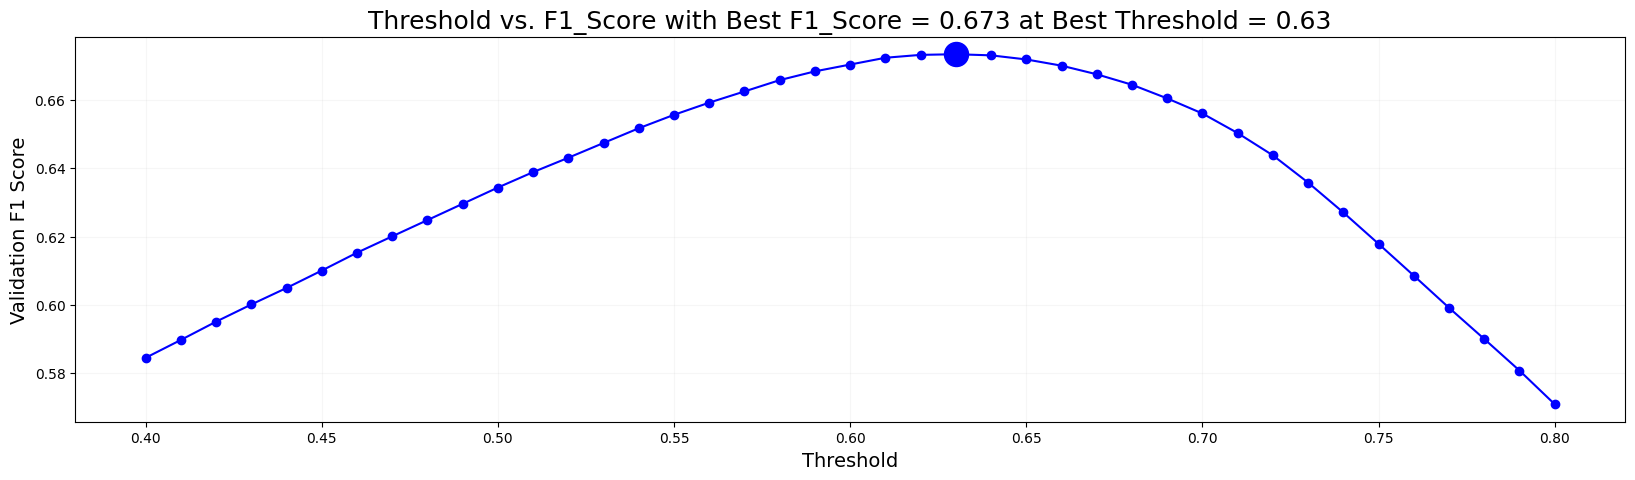

In [12]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize = (20, 5))
plt.plot(thresholds, scores, '-o', color = 'blue')
plt.scatter([best_threshold], [best_score], color = 'blue', s = 300, alpha = 1)
plt.xlabel('Threshold', size = 14)
plt.ylabel('Validation F1 Score', size = 14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}', size=18)
plt.grid(alpha=0.1)
plt.show()

In [13]:
print('When using optimal threshold...')
for k in range(18):

    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true_table[k].values, (out_prediction[k].values > best_threshold).astype('int'), average='macro')
    print(f'Question{k+1}: F1 =',m)

# COMPUTE F1 SCORE OVERALL
m = f1_score(true_table.values.reshape((-1)), (out_prediction.values.reshape((-1)) > best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Question1: F1 = 0.5580708621460972
Question2: F1 = 0.49463795470144134
Question3: F1 = 0.4867348589826809
Question4: F1 = 0.5934186878075811
Question5: F1 = 0.5579448173438034
Question6: F1 = 0.5994135673217628
Question7: F1 = 0.5752498102024082
Question8: F1 = 0.5269495979992822
Question9: F1 = 0.5896399475405351
Question10: F1 = 0.4761982929367803
Question11: F1 = 0.5800293765514071
Question12: F1 = 0.4771601761830952
Question13: F1 = 0.4248444987573632
Question14: F1 = 0.5985213930884559
Question15: F1 = 0.47642111278474913
Question16: F1 = 0.4556655285477098
Question17: F1 = 0.5394883278612543
Question18: F1 = 0.48732565982723736
==> Overall F1 = 0.6733673730636437


In [ ]:
print(out_prediction)

                         0         1         2         3         4         5   \
session_id                                                                      
20090312431273200  0.779464  0.986927  0.956615  0.845035  0.688855  0.846843   
20090312433251036  0.752163  0.980137  0.941633  0.571564  0.384448  0.615090   
20090312455206810  0.743615  0.978442  0.947949  0.645614  0.569263  0.866203   
20090313091715820  0.741239  0.982842  0.941179  0.780767  0.538492  0.832334   
20090313571836404  0.824519  0.986013  0.947474  0.856602  0.647115  0.875363   
...                     ...       ...       ...       ...       ...       ...   
22100215342220508  0.635932  0.979927  0.913579  0.824919  0.509368  0.734860   
22100215460321130  0.663798  0.977037  0.898011  0.739681  0.464234  0.696775   
22100217104993650  0.605076  0.974528  0.896456  0.862864  0.591119  0.820513   
22100219442786200  0.784620  0.984696  0.962326  0.795535  0.661728  0.847127   
22100221145014656  0.610576 

In [ ]:
print(true_table)

                   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  \
session_id                                                                      
20090312431273200   1   1   1   1   1   1   1   1   1   1   1   1   0   1   1   
20090312433251036   0   1   1   1   0   1   1   0   1   0   0   1   0   1   0   
20090312455206810   1   1   1   1   1   1   1   1   1   1   1   1   1   1   0   
20090313091715820   0   1   1   1   1   0   1   1   1   0   0   1   0   1   0   
20090313571836404   1   1   1   1   1   1   1   1   1   1   1   0   1   0   1   
...                ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
22100215342220508   1   1   1   1   1   1   1   0   1   1   1   1   0   1   1   
22100215460321130   0   1   1   1   0   1   1   0   1   0   1   1   0   1   0   
22100217104993650   1   1   1   1   1   1   1   1   1   0   1   1   1   1   0   
22100219442786200   0   1   1   1   1   1   1   0   1   0   1   1   0   1   0   
22100221145014656   0   1   